In [9]:
import sys
PROJECT_PATH = "/home/mrcong/Code/mylab-nilm-files/nilm-physical-features"
sys.path.append(f"{PROJECT_PATH}/src/common")

import numpy as np
import polars as pl
# from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import os
from tqdm import tqdm

# for DL modeling
import torch
# import torch.nn as nn
# import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.preprocessing import LabelEncoder
from ann_models import AnnRMSModel, MLPModel2
import logging
from model_eval import ModelEvaluation
from utils import extract_features
from nilm_dao import *
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import argparse
from sklearn.model_selection import train_test_split

# Configs
eval_batch_size = 512
window_size = 1800
model_name = "mlp_['Irms', 'P', 'MeanPF', 'S', 'Q'].pt"
is_norm = True
is_bn = False
dropout_rate = 0
data_type = "real_time"
dataset_name = "vndale1"
size = 1.0

# Setup other things
model_eval          = ModelEvaluation()
features            = extract_features(model_name)

# Model path
if dataset_name == "vndale1":
    model_path = f"{PROJECT_PATH}/results/models/VNDALE1/window_{window_size}/{len(features)}_comb"
elif dataset_name == "iawe":
    model_path = f"{PROJECT_PATH}/results/models/iawe/{len(features)}_comb"
elif dataset_name == "rae":
    model_path = f"{PROJECT_PATH}/results/models/rae/{len(features)}_comb"
else:
    raise ValueError("Invalid dataset name!")

state_dict_path     = f"{model_path}/{model_name}"
log_path            = f"{model_path}/model_evaluation"
log_file            = os.path.join(log_path, f"{model_name}_evaluation.log")
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler(sys.stdout)
    ]
)

def evaluate_pt_dataset(device, model:AnnRMSModel, test_loader:DataLoader):
    # Initialize lists to store evaluation metrics
    y_true_list = []
    y_pred_list = []
    y_hat_list = []
    
    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        for X, y in tqdm(iterable=test_loader, desc="Predicting"):
            # transfer data to GPU
            X = X.to(device)
            y = y.to(device)

            # Forward pass
            yHat = model(X)
            y_pred = torch.argmax(yHat, axis=1)

            # Calculate evaluation metrics
            y_true_list.extend(y.cpu().numpy())
            y_pred_list.extend(y_pred.cpu().numpy())
            y_hat_list.extend(yHat.cpu().numpy())
    y_true_list = np.array(y_true_list)
    y_pred_list = np.array(y_pred_list)
    y_hat_list = np.array(y_hat_list)
    return y_true_list, y_pred_list, y_hat_list
    
#Starting Main():
device = torch.device("cuda:0")
print(f"[+] Evaluation on {device} with model path: {state_dict_path}")

#Loading the data
print("[+] Loading data:")
if dataset_name == "vndale1":
    if data_type == "real_time":
        validation_df = pl.read_csv("/opt/nilm-shared-data/nilm_device_detection/VNDALE_v1/real_life_test/vndale1_test_sample.csv")
    else:
        validation_df = get_vndale1_data(data_type, window_size, is_norm)
elif dataset_name == "iawe":
    validation_df = get_iawe_data(data_type, is_norm)
elif dataset_name == "rae":
    validation_df = get_rae_data(data_type, is_norm)
else:
    raise ValueError("Invalid dataset name!")
print(validation_df.head())
label_encoder = get_label_encoder(dataset_name)

#Transform X_train and X_val to numpy
print("[+] Transform into numpy:")
X_train = validation_df.select(features).to_numpy()
y_train = validation_df["Label"].to_numpy()
if size < 1.0:
    X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=size, random_state=42, stratify=y_train)
# no_classes = len(np.unique(y_train))
no_classes = len(label_encoder.classes_)
#Change X, y to tensors, and setup
print("[+] Dataset information:")
X_val = torch.tensor(X_train).float()
y_val = torch.tensor(y_train)
print(f"[+] Validation set: {X_val.shape}, y_val: {y_val.shape}")

#Load the model
ann_rms = AnnRMSModel(input_dim=len(features), output_dim=no_classes, is_bn=is_bn, dropout=dropout_rate)
ann_rms.to(device)

# Load the previous model
if(os.path.isfile(state_dict_path)):
    logging.info(f"[+] Model load in : {state_dict_path}")
    ann_rms.load_state_dict(torch.load(state_dict_path))
    logging.info(f"[+] Model loaded!")
else:
    logging.error("[+] Model path not found!")
    exit()

#Train and validation dataloaders
val_dataDataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataDataset, batch_size=eval_batch_size, shuffle=False, drop_last=False, num_workers=12, pin_memory=True, persistent_workers=True)

#Evaluate model
pt_y_true, pt_y_pred, pt_y_hat = evaluate_pt_dataset(device=device, model=ann_rms, test_loader=val_loader)

[+] Evaluation on cuda:0 with model path: /home/mrcong/Code/mylab-nilm-files/nilm-physical-features/results/models/VNDALE1/window_1800/5_comb/mlp_['Irms', 'P', 'MeanPF', 'S', 'Q'].pt
[+] Loading data:
shape: (5, 11)
┌──────────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────┐
│ Time         ┆ In        ┆ Un        ┆ PF_n      ┆ … ┆ P         ┆ Q         ┆ S         ┆ Label │
│ ---          ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---   │
│ str          ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ i64   │
╞══════════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════╡
│ 2024-01-20_1 ┆ 0.14097   ┆ 1.3603    ┆ -0.214913 ┆ … ┆ -0.913466 ┆ 1.001461  ┆ -0.908356 ┆ 49    │
│ 4-40-10      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆       │
│ 2024-01-16_1 ┆ 0.132858  ┆ 1.267371  ┆ -0.1158   ┆ … ┆ -0.869248 ┆ 0.976548

/tmp/ipykernel_120869/1007258766.py:132: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ann_rms.load_state_dict(torch.load(state_dict_path))
Predicting: 100%|██████████| 196/

In [10]:
pt_y_hat.shape

(100096, 128)

In [14]:
import sys
PROJECT_PATH = "/home/mrcong/Code/mylab-nilm-files/nilm-physical-features"
sys.path.append(f"{PROJECT_PATH}/src/common")

import numpy as np
import polars as pl
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import os
from tqdm import tqdm
import onnxruntime as ort
import torch
import argparse
import logging
from model_eval import ModelEvaluation
from utils import extract_features
from nilm_dao import *
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

window_size = 1800
model_name = "mlp_['Irms', 'P', 'MeanPF', 'S', 'Q'].onnx"
is_norm = True
data_type = "real_time"
dataset_name = "vndale1"
size = 1

# Setup other things
model_eval = ModelEvaluation()
features = extract_features(model_name)

# Model path
if dataset_name == "vndale1":
    model_path = f"{PROJECT_PATH}/results/models/VNDALE1/window_{window_size}/{len(features)}_comb"
elif dataset_name == "iawe":
    model_path = f"{PROJECT_PATH}/results/models/iawe/{len(features)}_comb"
elif dataset_name == "rae":
    model_path = f"{PROJECT_PATH}/results/models/rae/{len(features)}_comb"
else:
    raise ValueError("Invalid dataset name!")

onnx_model_path = f"{model_path}/{model_name}"
log_path = f"{model_path}/model_evaluation"
log_file = os.path.join(log_path, f"{model_name}_evaluation.log")
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler(sys.stdout)
    ]
)

def evaluate_onnx_dataset(onnx_session, test_loader):
    y_true_list = []
    y_pred_list = []
    y_hat_list = []

    for X, y in tqdm(iterable=test_loader, desc="Predicting"):
        # Forward pass
        ort_inputs = {onnx_session.get_inputs()[0].name: X.numpy()}
        ort_outs = onnx_session.run(None, ort_inputs)
        y_pred = np.argmax(ort_outs[0], axis=1)

        # Calculate evaluation metrics
        y_true_list.extend(y.numpy())
        y_pred_list.extend(y_pred)
        y_hat_list.extend(ort_outs[0])
    y_true_list = np.array(y_true_list)
    y_pred_list = np.array(y_pred_list)
    y_hat_list = np.array(y_hat_list)
    return y_true_list, y_pred_list, y_hat_list

# Starting Main():
print(f"[+] Evaluation with model path: {onnx_model_path}")

# Loading the data
print("[+] Loading data:")
validation_df = pl.read_csv("/opt/nilm-shared-data/nilm_device_detection/VNDALE_v1/real_life_test/vndale1_test_sample.csv")
print(validation_df.head())

# Transform X_train and X_val to numpy
print("[+] Transform into numpy:")
X_train = validation_df.select(features).to_numpy()
y_train = validation_df["Label"].to_numpy()
if size < 1.0:
    X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=size, random_state=42, stratify=y_train)
no_classes = len(np.unique(y_train))
# Change X, y to tensors, and setup
print("[+] Dataset information:")
X_val = torch.tensor(X_train).float()
y_val = torch.tensor(y_train)
print(f"[+] Validation set: {X_val.shape}, y_val: {y_val.shape}")

# Load the ONNX model
onnx_session = ort.InferenceSession(onnx_model_path)

# Train and validation dataloaders
val_dataDataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataDataset, batch_size=1, shuffle=False, drop_last=False, num_workers=12, pin_memory=True, persistent_workers=True)

# Evaluate model
label_encoder = get_label_encoder(dataset_name)
onnx_y_true, onnx_y_pred, onnx_y_hat = evaluate_onnx_dataset(onnx_session=onnx_session, test_loader=val_loader)

[+] Evaluation with model path: /home/mrcong/Code/mylab-nilm-files/nilm-physical-features/results/models/VNDALE1/window_1800/5_comb/mlp_['Irms', 'P', 'MeanPF', 'S', 'Q'].onnx
[+] Loading data:
shape: (5, 11)
┌──────────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────┐
│ Time         ┆ In        ┆ Un        ┆ PF_n      ┆ … ┆ P         ┆ Q         ┆ S         ┆ Label │
│ ---          ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---   │
│ str          ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ i64   │
╞══════════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════╡
│ 2024-01-20_1 ┆ 0.14097   ┆ 1.3603    ┆ -0.214913 ┆ … ┆ -0.913466 ┆ 1.001461  ┆ -0.908356 ┆ 49    │
│ 4-40-10      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆       │
│ 2024-01-16_1 ┆ 0.132858  ┆ 1.267371  ┆ -0.1158   ┆ … ┆ -0.869248 ┆ 0.976548  ┆ -0.8

Predicting: 100%|██████████| 100096/100096 [00:41<00:00, 2415.73it/s]


In [15]:
# Compare shapes
print("Shapes comparison:")
print(f"onnx_y_true shape: {onnx_y_true.shape}")
print(f"pt_y_true shape: {pt_y_true.shape}")

# Check if arrays are exactly equal
are_equal = np.array_equal(onnx_y_true, pt_y_true)
print(f"\nArrays are exactly equal: {are_equal}")

# If not equal, find differences
if not are_equal:
    # Find indices where values differ
    diff_indices = np.where(onnx_y_true != pt_y_true)[0]
    print("\nDifferences found at indices:")
    for idx in diff_indices[:10]:  # Show first 10 differences
        print(f"Index {idx}: ONNX={onnx_y_true[idx]}, PT={pt_y_true[idx]}")
    
    if len(diff_indices) > 10:
        print(f"... and {len(diff_indices) - 10} more differences")

Shapes comparison:
onnx_y_true shape: (100096,)
pt_y_true shape: (100096,)

Arrays are exactly equal: True


In [16]:
# Compare shapes and check equality
print("Shapes comparison:")
print(f"ONNX predictions shape: {onnx_y_pred.shape}")
print(f"PyTorch predictions shape: {pt_y_pred.shape}")

# Check if predictions are exactly equal
pred_equal = np.array_equal(onnx_y_pred, pt_y_pred)
print(f"\nPredictions are exactly equal: {pred_equal}")

# If not equal, analyze differences
if not pred_equal:
    # Find indices where predictions differ
    diff_indices = np.where(onnx_y_pred != pt_y_pred)[0]
    print(f"\nFound {len(diff_indices)} differences")
    print("\nFirst 10 differences:")
    for idx in diff_indices[:10]:
        print(f"Index {idx}: ONNX={onnx_y_pred[idx]}, PyTorch={pt_y_pred[idx]}")
        
    # Calculate accuracy between the two predictions
    accuracy = np.mean(onnx_y_pred == pt_y_pred) * 100
    print(f"\nAccuracy between ONNX and PyTorch predictions: {accuracy:.2f}%")

Shapes comparison:
ONNX predictions shape: (100096,)
PyTorch predictions shape: (100096,)

Predictions are exactly equal: True


In [38]:
abs_diff

array([[          nan,           nan, 6.1035156e-04, ...,           nan,
        1.7605231e-03, 0.0000000e+00],
       [7.4752497e-05, 4.4013077e-04, 1.6914558e-03, ...,           nan,
        6.6860666e-04,           nan],
       [1.9531250e-03, 7.3079248e-03,           nan, ..., 0.0000000e+00,
                  nan, 1.5440809e-03],
       ...,
       [1.6648171e-03,           nan, 1.8411991e-03, ..., 5.5242716e-03,
                  nan, 2.7472600e-03],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
        7.8125000e-03, 7.8125000e-03]], dtype=float32)

In [41]:
import matplotlib.pyplot as plt

Euclidean Distance Statistics:
Mean distance: 0.00005815
Max distance: 0.00136730
Min distance: 0.00000323
Standard deviation: 0.00003577


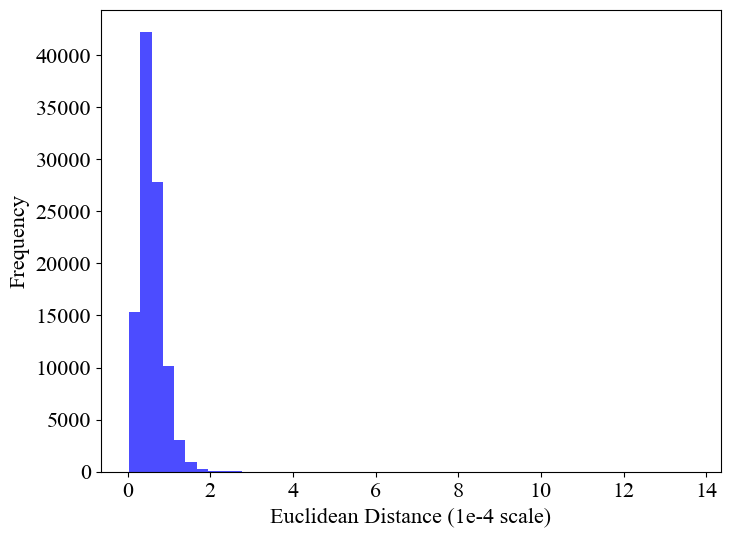

In [46]:
# Calculate Euclidean distance between ONNX and PyTorch y_hat values
euclidean_dist = np.linalg.norm(onnx_y_hat - pt_y_hat, axis=1)

# Calculate statistics
mean_dist = np.mean(euclidean_dist)
max_dist = np.max(euclidean_dist)
min_dist = np.min(euclidean_dist)
std_dist = np.std(euclidean_dist)

print("Euclidean Distance Statistics:")
print(f"Mean distance: {mean_dist:.8f}")
print(f"Max distance: {max_dist:.8f}")
print(f"Min distance: {min_dist:.8f}")
print(f"Standard deviation: {std_dist:.8f}")

# Plot histogram of distances
plt.figure(figsize=(8, 6))
plt.hist(euclidean_dist*1e4, bins=50, color='blue', alpha=0.7)
# plt.title('Histogram of Euclidean Distances\nbetween ONNX and PyTorch outputs')
plt.xlabel('Euclidean Distance (1e-4 scale)')
plt.ylabel('Frequency')
plt.show()
